In [1]:
import zipfile as zf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, Input, Lambda, Activation
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [2]:
cd ..

/


In [4]:
#extract data from zip file
files = zf.ZipFile("storage/zipped_data.zip", 'r')
files.extractall("storage/data")
files.close()

In [15]:
#load in data frame with paths to images
df = pd.read_csv('storage/path_df.csv', index_col=0)

In [16]:
df['masks'] = 'storage\\' + df.masks 
df['scans'] = 'storage\\'+df.scans
df['masks'] = df.masks.str.replace("\\","/" )
df['scans'] = df.scans.str.replace("\\", "/")

In [17]:
df.head(5)

,masks,scans
0,storage/data/lgg-mri-segmentation/TCGA_CS_4941...,storage/data/lgg-mri-segmentation/TCGA_CS_4941...
1,storage/data/lgg-mri-segmentation/TCGA_CS_4941...,storage/data/lgg-mri-segmentation/TCGA_CS_4941...
2,storage/data/lgg-mri-segmentation/TCGA_CS_4941...,storage/data/lgg-mri-segmentation/TCGA_CS_4941...
3,storage/data/lgg-mri-segmentation/TCGA_CS_4941...,storage/data/lgg-mri-segmentation/TCGA_CS_4941...
4,storage/data/lgg-mri-segmentation/TCGA_CS_4941...,storage/data/lgg-mri-segmentation/TCGA_CS_4941...


In [10]:
#calculate percentage of tumor pixels
total_pixels = len(df) * 256 * 256
tumor_pixels = 0
for index in range(len(df)):
    for row in plt.imread(df.iloc[index].masks):
        for pix in row:
            if pix > 0:
                tumor_pixels +=1
percentage = round((tumor_pixels / total_pixels) * 100,2)
print('percentage of pixels that are tumors:',percentage)

percentage of pixels that are tumors: 1.03


In [18]:
#find and drop all images that do not contain any tumor pixels
tumorless_indices = []
for row in range(len(df)):
    if sum(plt.imread(df.iloc[row].masks)).any() == 0:
        tumorless_indices.append(row)
len(tumorless_indices)

2556

In [19]:
df = df.drop(tumorless_indices)

In [20]:
len(df)

1373

In [21]:
#split data into training, testing, and validation sets
df_train, df_test = train_test_split(df, test_size = .1)
df_train, df_val = train_test_split(df_train, test_size = .1)

In [22]:
#define functions that finds the edges of the tumors
def upper_limit(mask, padding):
    upper_lim = 0
    #go through each row until a row with a non zero pixel is found
    for row in mask:
        upper_lim +=1
        if sum(row) != 0:
             return max(0,upper_lim - padding) 
            
def lower_limit(mask, padding):
    lower_lim = 256
    #go through each row backwards until a non zero pixel is found
    for i in range(255,0,-1):
        lower_lim += -1
        if sum(mask[i])!=0:
            return min(256,lower_lim+padding)
        
def left_limit(mask, padding):
    left_lim = 256
    #skip rows with all zero pixels
    for row in mask:
        if sum(row) != 0:
            found = False
            #go through all rows until a non zero pixel is found
            while not found:
                for i, pix in enumerate(row):
                    if pix !=0:
                        found = True
                        #find the lowest position with a non zero pixel
                        if i < left_lim:
                            left_lim = i
    return max(1, left_lim - padding)
            
def right_limit(mask, padding):
    right_lim = 0
    #skip rows with all zero pixels
    for row in mask:
        if sum(row) != 0:
            found = False
            #go through all rows backwards until a non zero pixel is found
            while not found:
                for pix in range(255,0,-1):
                    if row[pix] != 0:
                        found = True
                        #find the highest position with a non zero pixel
                        if pix > right_lim:
                            right_lim = pix
    return min(256, right_lim + padding)

In [29]:
#define a function that crops the image around the tumor, padded by a random number of pixels
def crop_image(img, mask, pad_limit):
    if sum(sum(mask)) == 0:
        return img/255, mask/255
    else:
        padding = random.randint(10, pad_limit) #random number of pixels to pad tumor between 10 and the pad_limit
        #find tumor boundaries
        upper = upper_limit(mask, padding)
        lower= lower_limit(mask, padding)
        left = left_limit(mask, padding)
        right = right_limit(mask, padding)
        #crop images according to boundary, with random padding
        cropped_mask = mask[upper:lower, left:right]
        cropped_img = img[upper:lower, left:right,:]
        #resize cropped image back to 256x256
        resized_mask = resize(cropped_mask, (256,256)) #note: resizing also scales pixels by 255
        resized_img = resize(cropped_img,(256,256,3))
        return resized_img, resized_mask

In [74]:
#define a function to prepare data
PAD_LIMIT = 200
def prepare_data(df, train=False):
    images = []
    masks = []
    #read in each path from the data frame and form images into an array
    for i in range(len(df)):
        img = plt.imread(df.iloc[i].scans)
        msk = plt.imread(df.iloc[i].masks)
        images.append(img)
        masks.append(msk)
    images = np.array(images) #shape: (len(df), 256,256,3)
    masks = np.array(masks) #shape: (len(df), 256,256)
    
    #crop each image for training data only
    if train:
        cropped_images = []
        cropped_masks = []
        for img, mask in zip(images, masks):
            img, mask = crop_image(img, mask, PAD_LIMIT)
            cropped_images.append(img)
            cropped_masks.append(mask)
        cropped_images = np.array(cropped_images, dtype='float32')
        cropped_masks = np.array(cropped_masks, dtype='float32')
        cropped_masks = cropped_masks.reshape(len(df), 256,256, 1) #reshape mask array into 4 dimensions
        return cropped_images, cropped_masks
    
    #scale masks and images by 255 and convert to float data type
    images = images.astype('float32')/255
    masks = masks/255
    masks = masks.astype('float32')
    masks = masks.reshape(len(df), 256,256,1) #reshape mask array into 4 dimensions
    
    return images, masks

In [75]:
#create training, validation, and test data
train_data = prepare_data(df_train, train=True)
val_data= prepare_data(df_val)
test_data = prepare_data(df_test)

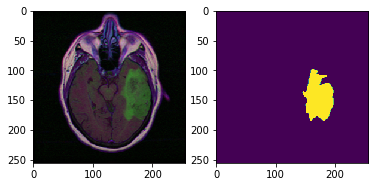

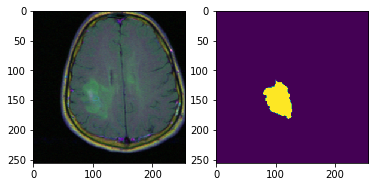

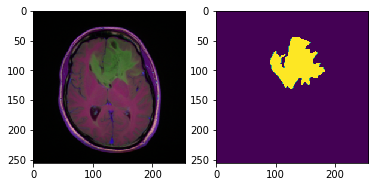

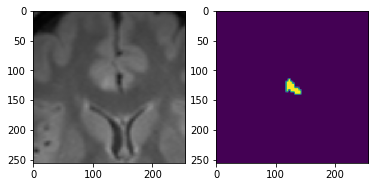

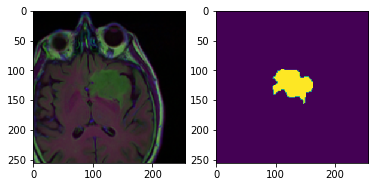

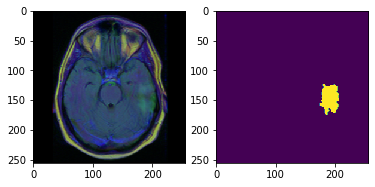

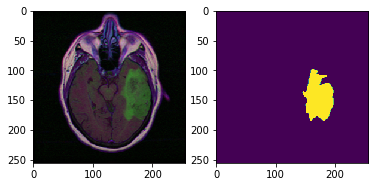

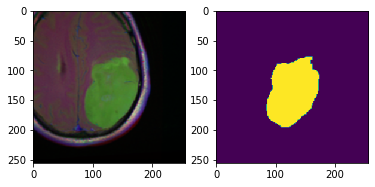

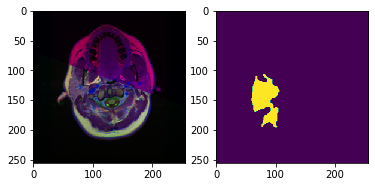

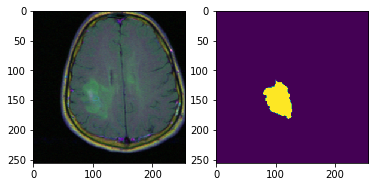

In [76]:
#sample of prepared training data  
sample_df = df.sample(50)
sample_data = prepare_data(sample_df, train=True)
def samples(n):
    ims, msks = sample_data
    for i in range(n):
        index = random.randint(0, len(ims))
        plt.subplots(1,2)
        plt.subplot(1,2,1)
        plt.imshow(ims[index])
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(msks[index]))
samples(10)

In [93]:
#calculate percentage of nonzero pixels
total_pixels = len(df_train) * 256 * 256
tumor_pixels = 0
for img in train_data[1]:
    for row in img:
        for pix in row:
            if pix > 0:
                tumor_pixels +=1
tumor_pixels / total_pixels *100

6.303779334232251

In [77]:
#custom loss and metric functions
#note: dice coefficient good for imbalanced classes, similar to F1 score
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [78]:
#define unet block functions
def encoder_block(n_filters, inputs):
    c1 = Conv2D(n_filters,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    #d = Dropout(0.2)(c1)
    c2 = Conv2D(n_filters,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    bn = BatchNormalization()(c2)
    p = MaxPooling2D((2,2))(bn)
    return (c2,p)  

def decoder_block(n_filters, inputs, concat_layer):
    u = Conv2DTranspose(n_filters,(2,2), strides=(2,2), padding='same')(inputs)
    u = concatenate([u, concat_layer])
    c1 = Conv2D(n_filters,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u)
    #d = Dropout(0.2)(c1)
    c2 = Conv2D(n_filters,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    bn = BatchNormalization()(c2)
    return bn

def bottleneck(n_filters, inputs):
    c1 = Conv2D(n_filters,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    #d = Dropout(0.2)(c1)
    c2 = Conv2D(256,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    bn = BatchNormalization()(c2)
    return bn

In [79]:
#build unet
EPOCHS=100
lr = .001
def unet():
    #image dimmensions
    IMG_WIDTH = 256
    IMG_HEIGHT = 256
    IMG_CHANNELS = 3
    
    #input layer
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    
    #encoder
    n_filters = [64,128,256,512]
    c_layers = []
    p = inputs
    for n in n_filters:
        c, p = encoder_block(n, p)
        c_layers.append(c)
       
    #bottleneck
    c = bottleneck(1024, p)
    
    #decoder
    n_filters.reverse()
    for n in n_filters:
        c = decoder_block(n,c, c_layers.pop())
        
    #output layer
    outputs = Conv2D(1,(1,1), activation='sigmoid')(c)
    
    #compile model
    model = Model(inputs=[inputs], outputs=[outputs])
    opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=None, decay=lr/EPOCHS)
    model.compile(optimizer=opt, loss=dice_coef_loss, metrics=['binary_accuracy', dice_coef])
    model.summary()
    return model

In [80]:
model = unet()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 256, 256, 64) 256         conv2d_20[0][0]                  
____________________________________________________________________________________________

In [81]:
BATCH_SIZE = 16
#separate images and masks
X,y = train_data
X_val, y_val = val_data

#define callbacks
callbacks = [ModelCheckpoint('storage/full_unet_model.h5', verbose=1, save_best_only=True)]
            #EarlyStopping(monitor='val_loss',patience=20)]
#train model
history = model.fit(X,y, steps_per_epoch= len(df_train)/ BATCH_SIZE, epochs=EPOCHS, validation_data = [X_val, y_val], validation_steps=len(df_val)/BATCH_SIZE, callbacks = callbacks, batch_size = BATCH_SIZE)

Epoch 1/100
1104/1111 [============================>.] - ETA: 0s - loss: 0.7149 - binary_accuracy: 0.7832 - dice_coef: 0.2851
Epoch 00001: val_loss improved from inf to 0.72671, saving model to storage/full_unet_model.h5
1111/1111 [==============================] - 36s 32ms/sample - loss: 0.7142 - binary_accuracy: 0.7842 - dice_coef: 0.2866 - val_loss: 0.7267 - val_binary_accuracy: 0.8437 - val_dice_coef: 0.2700
Epoch 2/100
1104/1111 [============================>.] - ETA: 0s - loss: 0.6166 - binary_accuracy: 0.9001 - dice_coef: 0.3834
Epoch 00002: val_loss improved from 0.72671 to 0.70173, saving model to storage/full_unet_model.h5
1111/1111 [==============================] - 31s 28ms/sample - loss: 0.6178 - binary_accuracy: 0.8997 - dice_coef: 0.3807 - val_loss: 0.7017 - val_binary_accuracy: 0.9716 - val_dice_coef: 0.2950
Epoch 3/100
1104/1111 [============================>.] - ETA: 0s - loss: 0.5971 - binary_accuracy: 0.9075 - dice_coef: 0.4029
Epoch 00003: val_loss improved from 0.

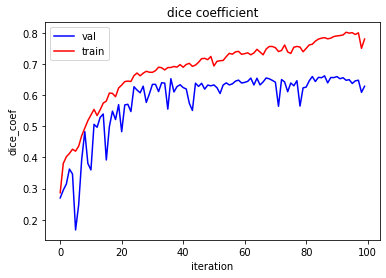

In [82]:
#plot train/val scores
metrics = history.history

train_dice = metrics['dice_coef']
val_dice = metrics['val_dice_coef']


plt.plot(val_dice, 'b-', label='val')
plt.plot(train_dice, 'r-', label='train')
plt.xlabel('iteration')
plt.ylabel('dice_coef')
plt.title('dice coefficient')
plt.legend()
plt.savefig('storage/dice_coef_graph_full_unet.png')
plt.show()

In [87]:
#load last saved model
model = tf.keras.models.load_model('storage/full_unet_model.h5', custom_objects={'dice_coef_loss':dice_coef_loss, 'dice_coef':dice_coef})

In [88]:
#evaluate model on train and test data
X_test, y_test = test_data 
X_train, y_train = train_data
train_results = model.evaluate(X_train, y_train, verbose=0)
test_results = model.evaluate(X_test, y_test, verbose=0)

In [89]:
results_df = pd.DataFrame([train_results, test_results], index=['train', 'test'], columns=['loss', 'accuracy', 'dice_coef'])

In [90]:
results_df

,loss,accuracy,dice_coef
train,0.210644,0.974906,0.789713
test,0.341435,0.985740,0.658086


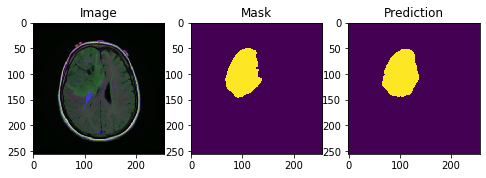

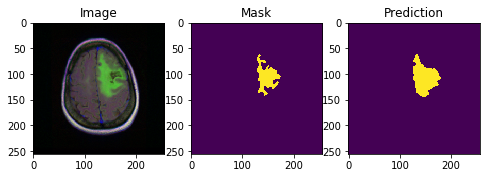

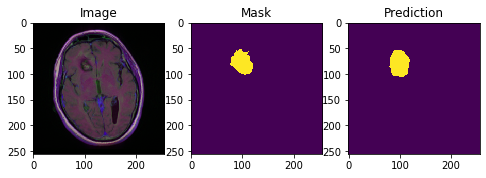

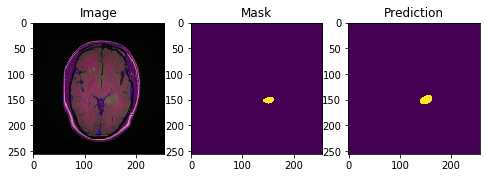

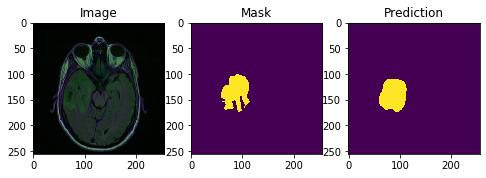

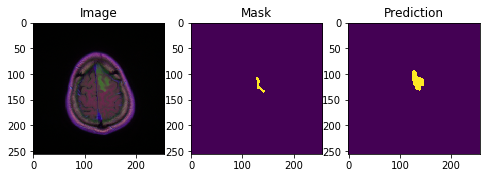

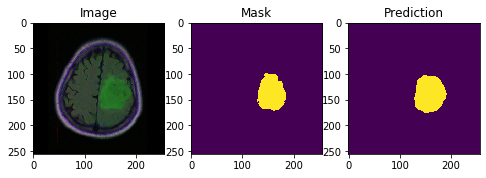

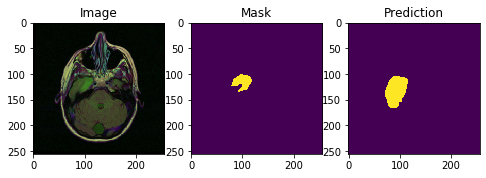

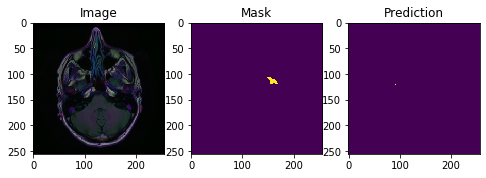

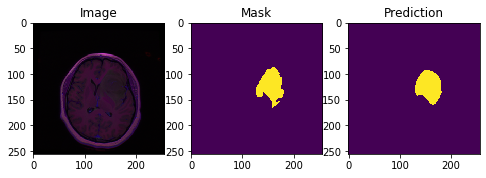

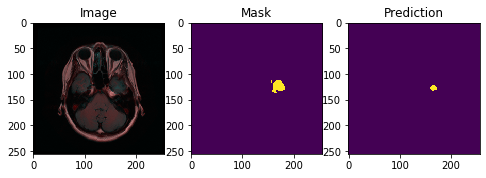

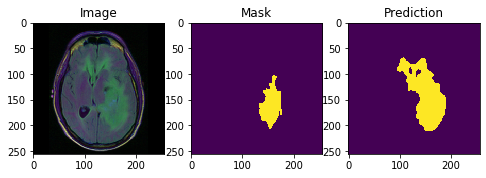

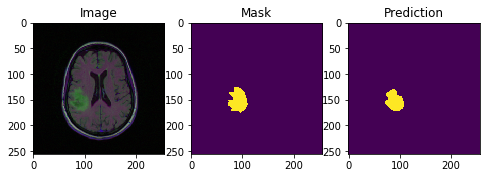

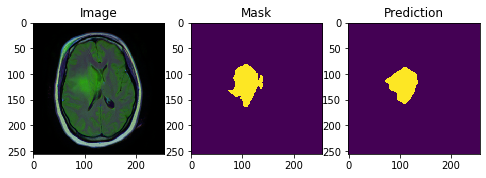

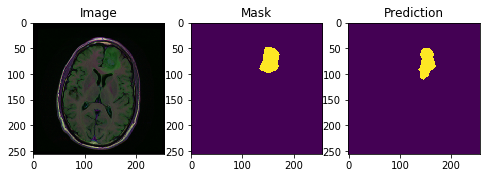

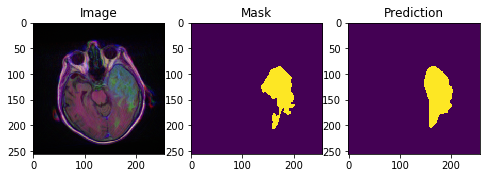

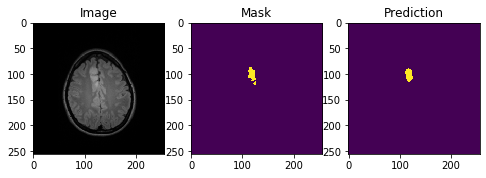

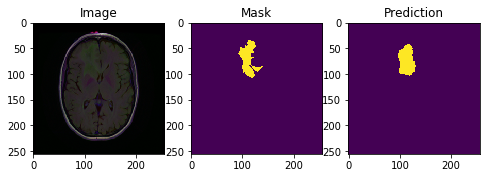

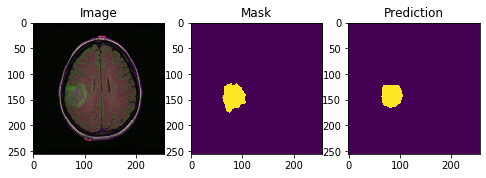

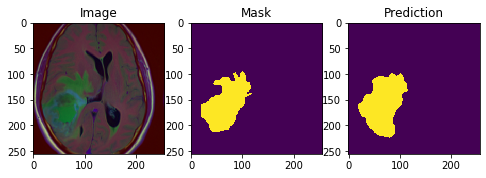

In [92]:
#visual analysis of predictions
def plot_predictions(n, df):
    df_plot = df.copy().reset_index(drop=True)
    for i in range(n):
        index=np.random.randint(1,len(df_plot.index))
        img = plt.imread(df_plot['scans'].iloc[index])
        img = img / 255
        img = img.reshape(1,256,256,3)
        pred=model.predict(img)
        pred[pred < .5] = 0
        pred[pred >= .5] = 1
        mask = plt.imread(df_plot['masks'].iloc[index])
        df_plot = df_plot.drop(index).reset_index(drop=True)
        
        plt.figure(figsize=(8,8))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(img))
        plt.title('Image')
        plt.subplot(1,3,2)
        plt.imshow(np .squeeze(mask))
        plt.title('Mask')
        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(pred))
        plt.title('Prediction')
        plt.show()
plot_predictions(20, df_test)